# **Brain Tumor MRI**


## **Introduction :**
A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.

## **About DatsSet :**
This dataset is a combination of the following three datasets :
figshare
SARTAJ dataset
Br35H

This dataset contains 7022 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary.

no tumor class images were taken from the Br35H dataset.

You can download the dataset from [kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

## **Dependencies :**
- Google Colab
- Tensorflow 2.9.2
- Python 3.7.15
- Matplotlib
- Scikit-Learn
- Pandas
- Numpy
- Keras
- VGG16

Install dependencies using [conda](https://docs.conda.io/en/latest/)

## **TODO :**
- Pick the dataset from [kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- Download the dataset using opendatasets
- Filter out corupted images
- Shuffle the Train, Test datset
- Data Augmentation
- Visualize the Augmented data
- Build the Model
- Train the Model
- Save the Model

## **📥Download DataSet**

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

# Url link of kaggle dataset
dataset_url = 'https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset'

# Download dataset
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rafikulmondal
Your Kaggle Key: ··········


100%|██████████| 149M/149M [00:00<00:00, 212MB/s]


##**⚙️Setup**

In [6]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt

# Miscellaneous
import os
import random

In [4]:
!ls

brain-tumor-mri-dataset  sample_data


In [5]:
!ls brain-tumor-mri-dataset

Testing  Training


## **Filter out corrupted Images**
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [7]:
num_skipped = 0
for folder_name in ("glioma", "meningioma", "notumor", "pituitary"):
    folder_path = os.path.join("/content/brain-tumor-mri-dataset/Training", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 8 images


## **Shuffle the Train and Test Data**
Shuffle the image for give variation to the model. So, model can learn better.

In [8]:
# Train data shuffle
train_dir = '/content/brain-tumor-mri-dataset/Training/'
test_dir = '/content/brain-tumor-mri-dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [9]:
# Test data shuffle
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

## **Image Data Augmentation**
This Brai-Tumor-MRI dataset is small so, I'm artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as

- Brightness enhance
- Contrast enhance


This helps expose the model to different aspects of the training data while slowing down overfitting.


In [10]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

## **Visualize the Data**
After augmentation Visualization of some images.

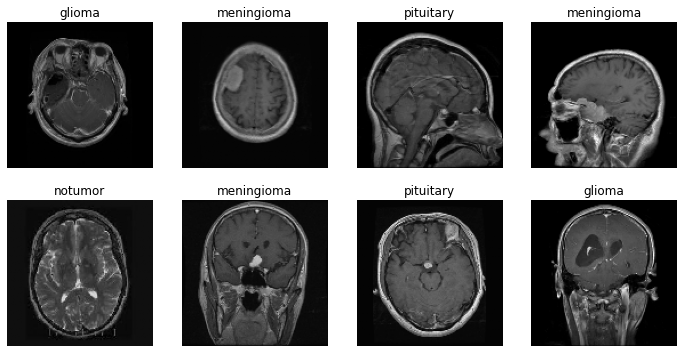

In [11]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [12]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

##**Model Build**
I used transfer learning for this dataset. As a transfer learning I used VGG16 model.

Note :
- I start the model with a Sequential layer.
- I resize the sahpe of imgaes
- I added VGG16 model
- Then i flatten the model
- I include drop out layer(0.3) 
- I added a dense layer
- Again i added one more drop out layer(0.2) before final classification layer
- Then i added final Dense layer for classification

In [13]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
# compile the model accuracy and loss is sparse_categorical_accuracy and crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

## **Train the Model**
I used 20 batch size and i trained the model for 5 epochs only. and accuracy of the model is 96%

In [15]:
# Train the model
batch_size = 20   # batch size = 20
steps = int(len(train_paths)/batch_size)      # steps per epochs (5700/20) = 285
epochs = 5  # epochs = 5
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),    # fit the model
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 [==============================] - 32s 78ms/step - loss: 0.4517 - sparse_categorical_accuracy: 0.8288
Epoch 2/5
285/285 [==============================] - 23s 78ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9189
Epoch 3/5
285/285 [==============================] - 22s 78ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.9428
Epoch 4/5
285/285 [==============================] - 22s 79ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9653
Epoch 5/5
285/285 [==============================] - 23s 79ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9646


## **Save**
After completed the training of model i saved the model as .h5 file.

In [16]:
from keras.models import load_model

# save the model as .h5 file
model.save('brain-tumor-MRI_model.h5')   